In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
DATASET_FILEPATH = Path("data/mWIG40.csv")

We will omit NaN values, because we want to investigate the possibility of optimization instead of full analysis.

In [3]:
df = pd.read_csv(DATASET_FILEPATH, parse_dates=["Date"], index_col="Date")
df.head()

,EAT,ASB,HUGE,WPL,DVL,MBK,ATT,KTY,XTB,EUR,...,MIL,TEN,KRU,ENA,NEU,SLV,KER,BDX,PKP,11B
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-27,-0.001290,-0.004174,-0.070012,0.043896,0.003282,0.019863,-0.013213,0.003120,0.007316,0.025422,...,0.057402,0.000932,0.023107,-0.019898,0.012690,0.000000,-0.005329,-0.004698,0.010331,0.001984
2021-05-28,0.006460,-0.022987,0.007432,-0.031986,0.024518,0.007388,0.046257,0.001672,-0.011173,0.056333,...,0.028571,0.014043,0.042015,-0.003480,-0.012531,-0.002614,0.032143,-0.023957,0.053170,0.007921
2021-05-31,0.029525,-0.087829,0.029508,-0.010397,0.036670,0.008000,0.003490,0.041736,-0.014689,-0.016880,...,-0.009921,-0.007843,0.000000,0.009895,0.001269,-0.005242,0.001730,0.031091,0.024272,-0.005894
2021-06-01,0.005611,0.154950,-0.004777,-0.015760,0.061537,0.015212,-0.028406,-0.022436,-0.008028,0.010603,...,0.012024,0.000000,0.015499,0.009798,0.007605,-0.048748,-0.015544,0.001693,0.004739,-0.018182
2021-06-02,0.013639,-0.060952,0.045333,0.003528,0.000000,-0.022801,0.014916,-0.029508,0.019075,-0.006566,...,0.001980,0.050230,0.063355,0.038813,-0.006289,0.027701,0.007018,-0.013379,0.000000,0.022544


## Plot of daily returns

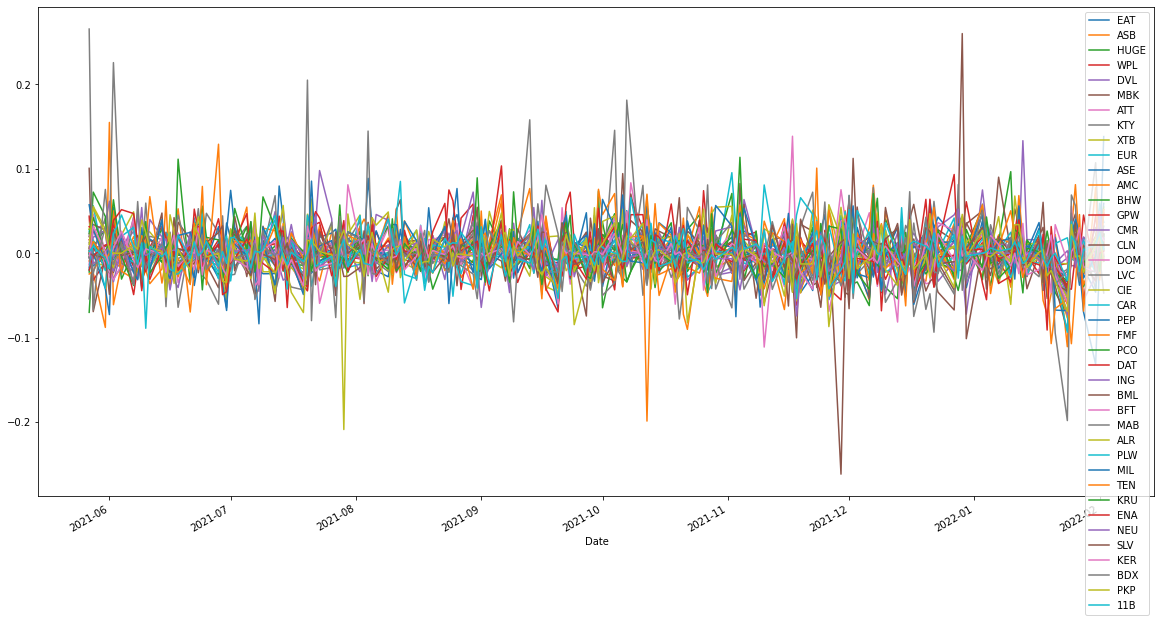

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(ax=ax)
plt.show()

## Mean and standard deviation of daily returns

In [5]:
mean_std_df = df.agg(["mean", "std"]).transpose()

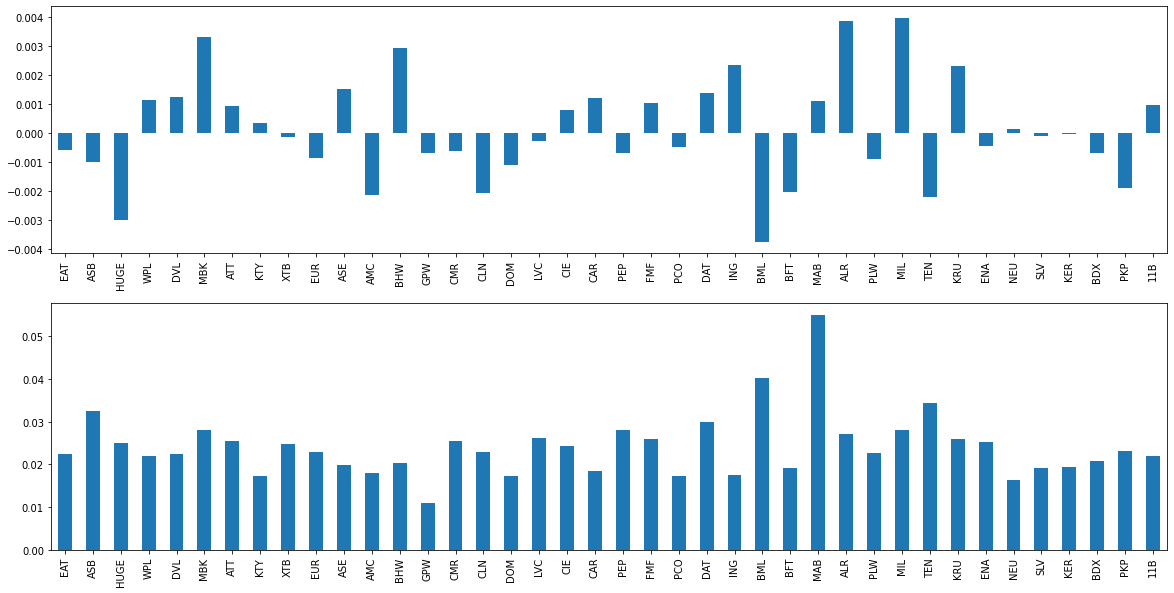

In [6]:
fig, axs = plt.subplots(2, figsize=(20, 10))
mean_std_df["mean"].plot(kind="bar", ax=axs[0])
mean_std_df["std"].plot(kind="bar", ax=axs[1])
plt.show()

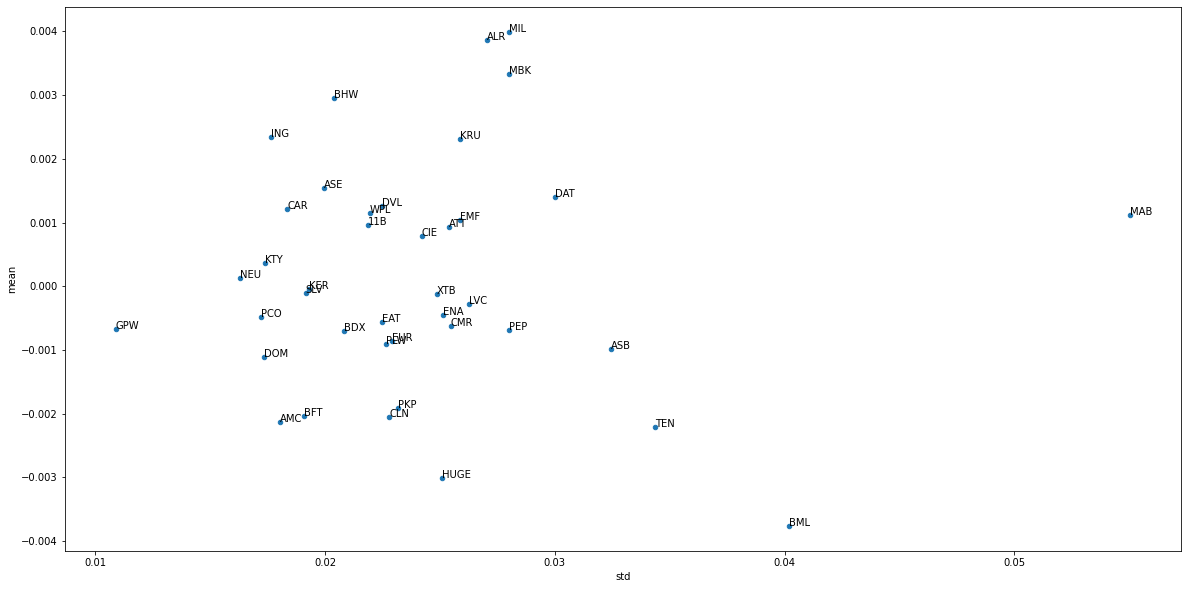

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("std", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["std"], row["mean"]))

plt.show()

## Correlation matrix of daily returns

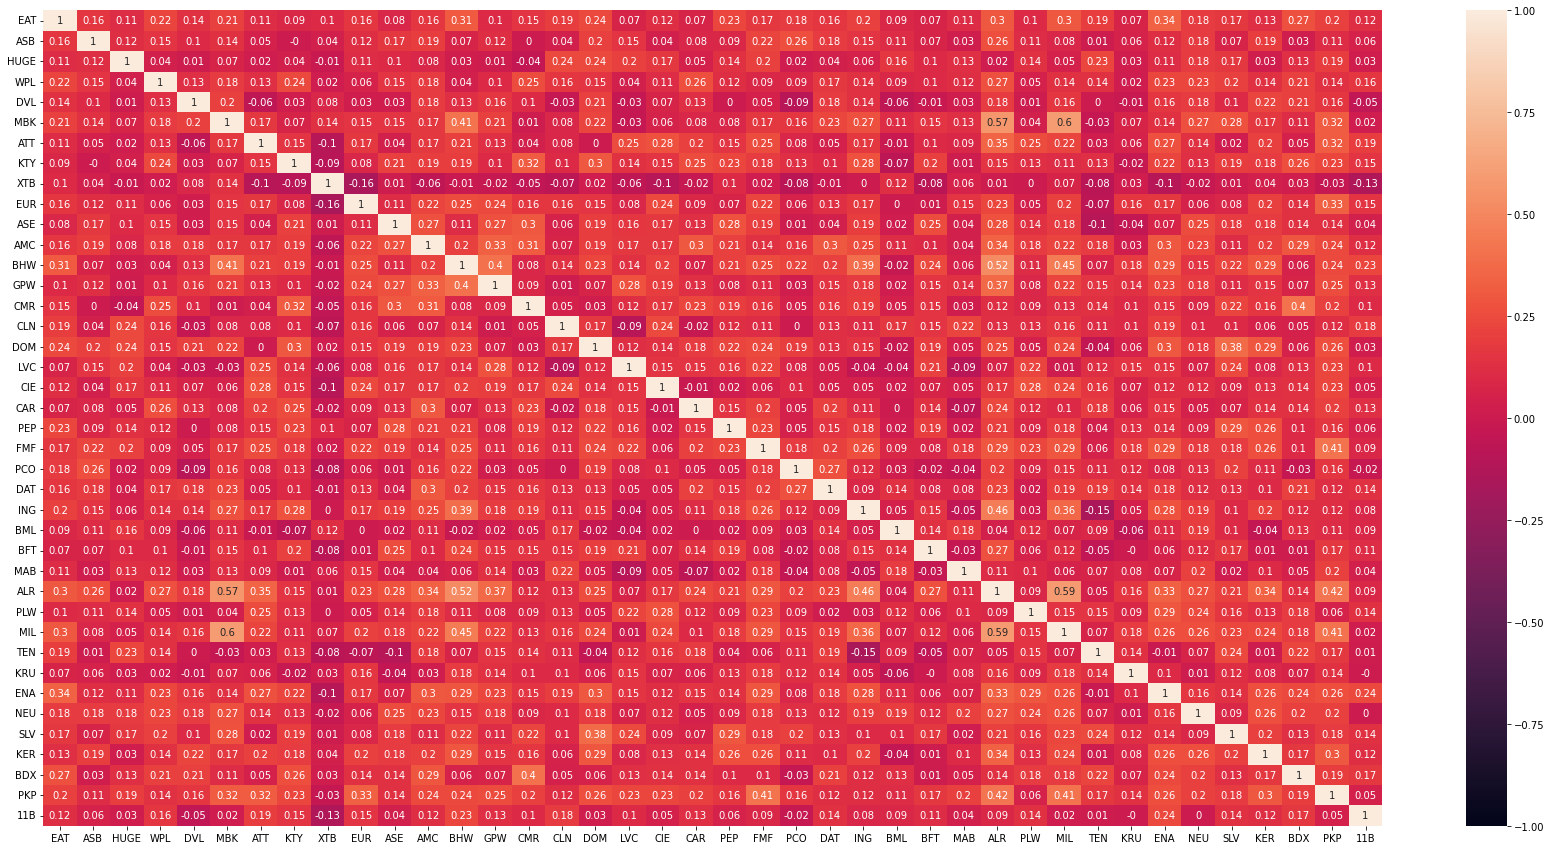

In [8]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(df.corr().round(2), ax=ax, annot=True, vmin=-1, vmax=1)
plt.show()

## Modern portfolio theory

In [9]:
from qpsolvers import solve_qp

In [10]:
SIGMA = df.cov().to_numpy()
R = df.mean().to_numpy()

In [11]:
def get_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1))

def get_nonnegative_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1), np.zeros_like(R))

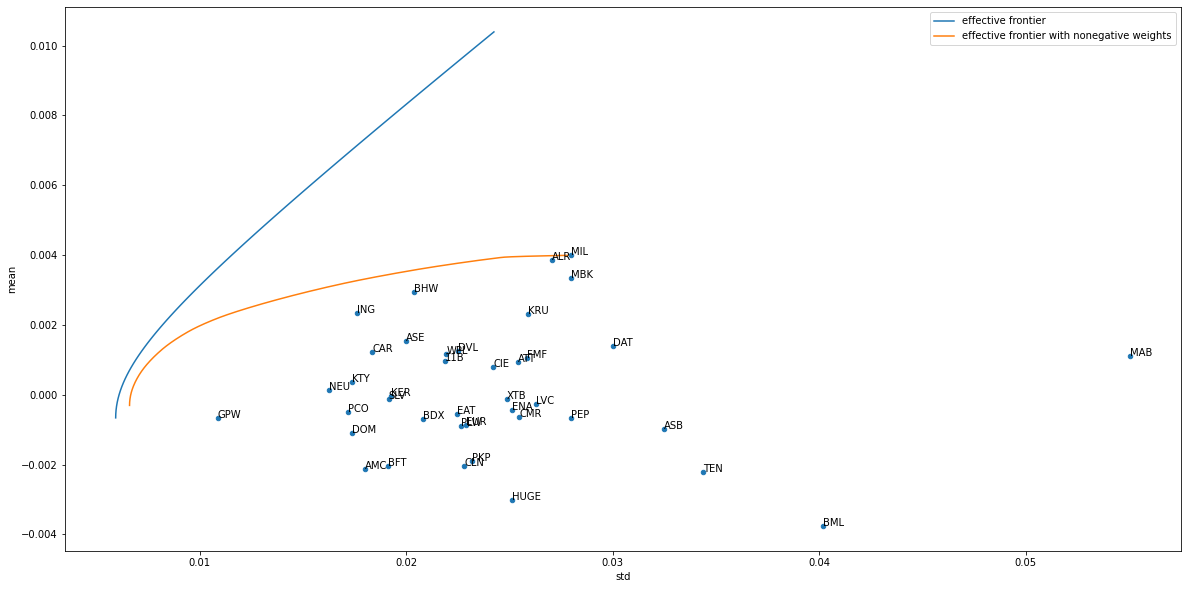

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("std", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["std"], row["mean"]))

arr = []
for q in np.linspace(0, 0.1, 100):
    w = get_weights(q)
    vol, ret = np.sqrt(w.T @ SIGMA @ w), np.dot(R, w)
    arr.append([vol, ret])

nonneg_arr = []
for q in np.linspace(0, 5, 100000):
    w = get_nonnegative_weights(q)
    vol, ret = np.sqrt(w.T @ SIGMA @ w), np.dot(R, w)
    nonneg_arr.append([vol, ret])

arr = np.array(arr)
nonneg_arr = np.array(nonneg_arr)
ax.plot(arr[:, 0], arr[:, 1], label="effective frontier")
ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights")
ax.legend()
plt.show()

# Experiments with NSGA2

In [13]:
from nsga2.objectives import get_objective, portfolios_neg_returns, portfolios_vars, portfolios_empirical_VaR, portfolios_semivariances
from nsga2.model import NSGA2

from functools import partial

In [14]:
temp_df = df.agg(["mean"]).T
temp_df["variance"] = portfolios_vars(np.eye(len(df.columns)), SIGMA)
temp_df["semivariance"] = portfolios_semivariances(np.eye(len(df.columns)), np.asarray(df))
temp_df["VaR95"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.95)
temp_df["VaR99"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.99)
temp_df.head()

,mean,variance,semivariance,VaR95,VaR99
EAT,-0.000566,0.000505,0.000419,0.033576,0.047827
ASB,-0.000984,0.001053,0.000990,0.055168,0.088455
HUGE,-0.003013,0.000630,0.000546,0.039217,0.066049
WPL,0.001157,0.000481,0.000378,0.031223,0.043248
DVL,0.001256,0.000506,0.000383,0.029097,0.046176


In [15]:
weights_arr = []
for q in np.linspace(0, 0.2, 10000):
    weights_arr.append(get_weights(q))
weights_arr = np.asarray(weights_arr)

In [16]:
objective = get_objective(
    partial(portfolios_neg_returns, R=R),
    partial(portfolios_vars, SIGMA=SIGMA),
    partial(portfolios_semivariances, returns=np.asarray(df)),
    partial(portfolios_empirical_VaR, returns=np.asarray(df), alpha=0.95),
    partial(portfolios_empirical_VaR, returns=np.asarray(df), alpha=0.99),
)

In [17]:
model = NSGA2(len(R), population_size=500, n_iterations=512)

In [18]:
history = model.simulate(objective)

100%|██████████| 512/512 [00:40<00:00, 12.71it/s]


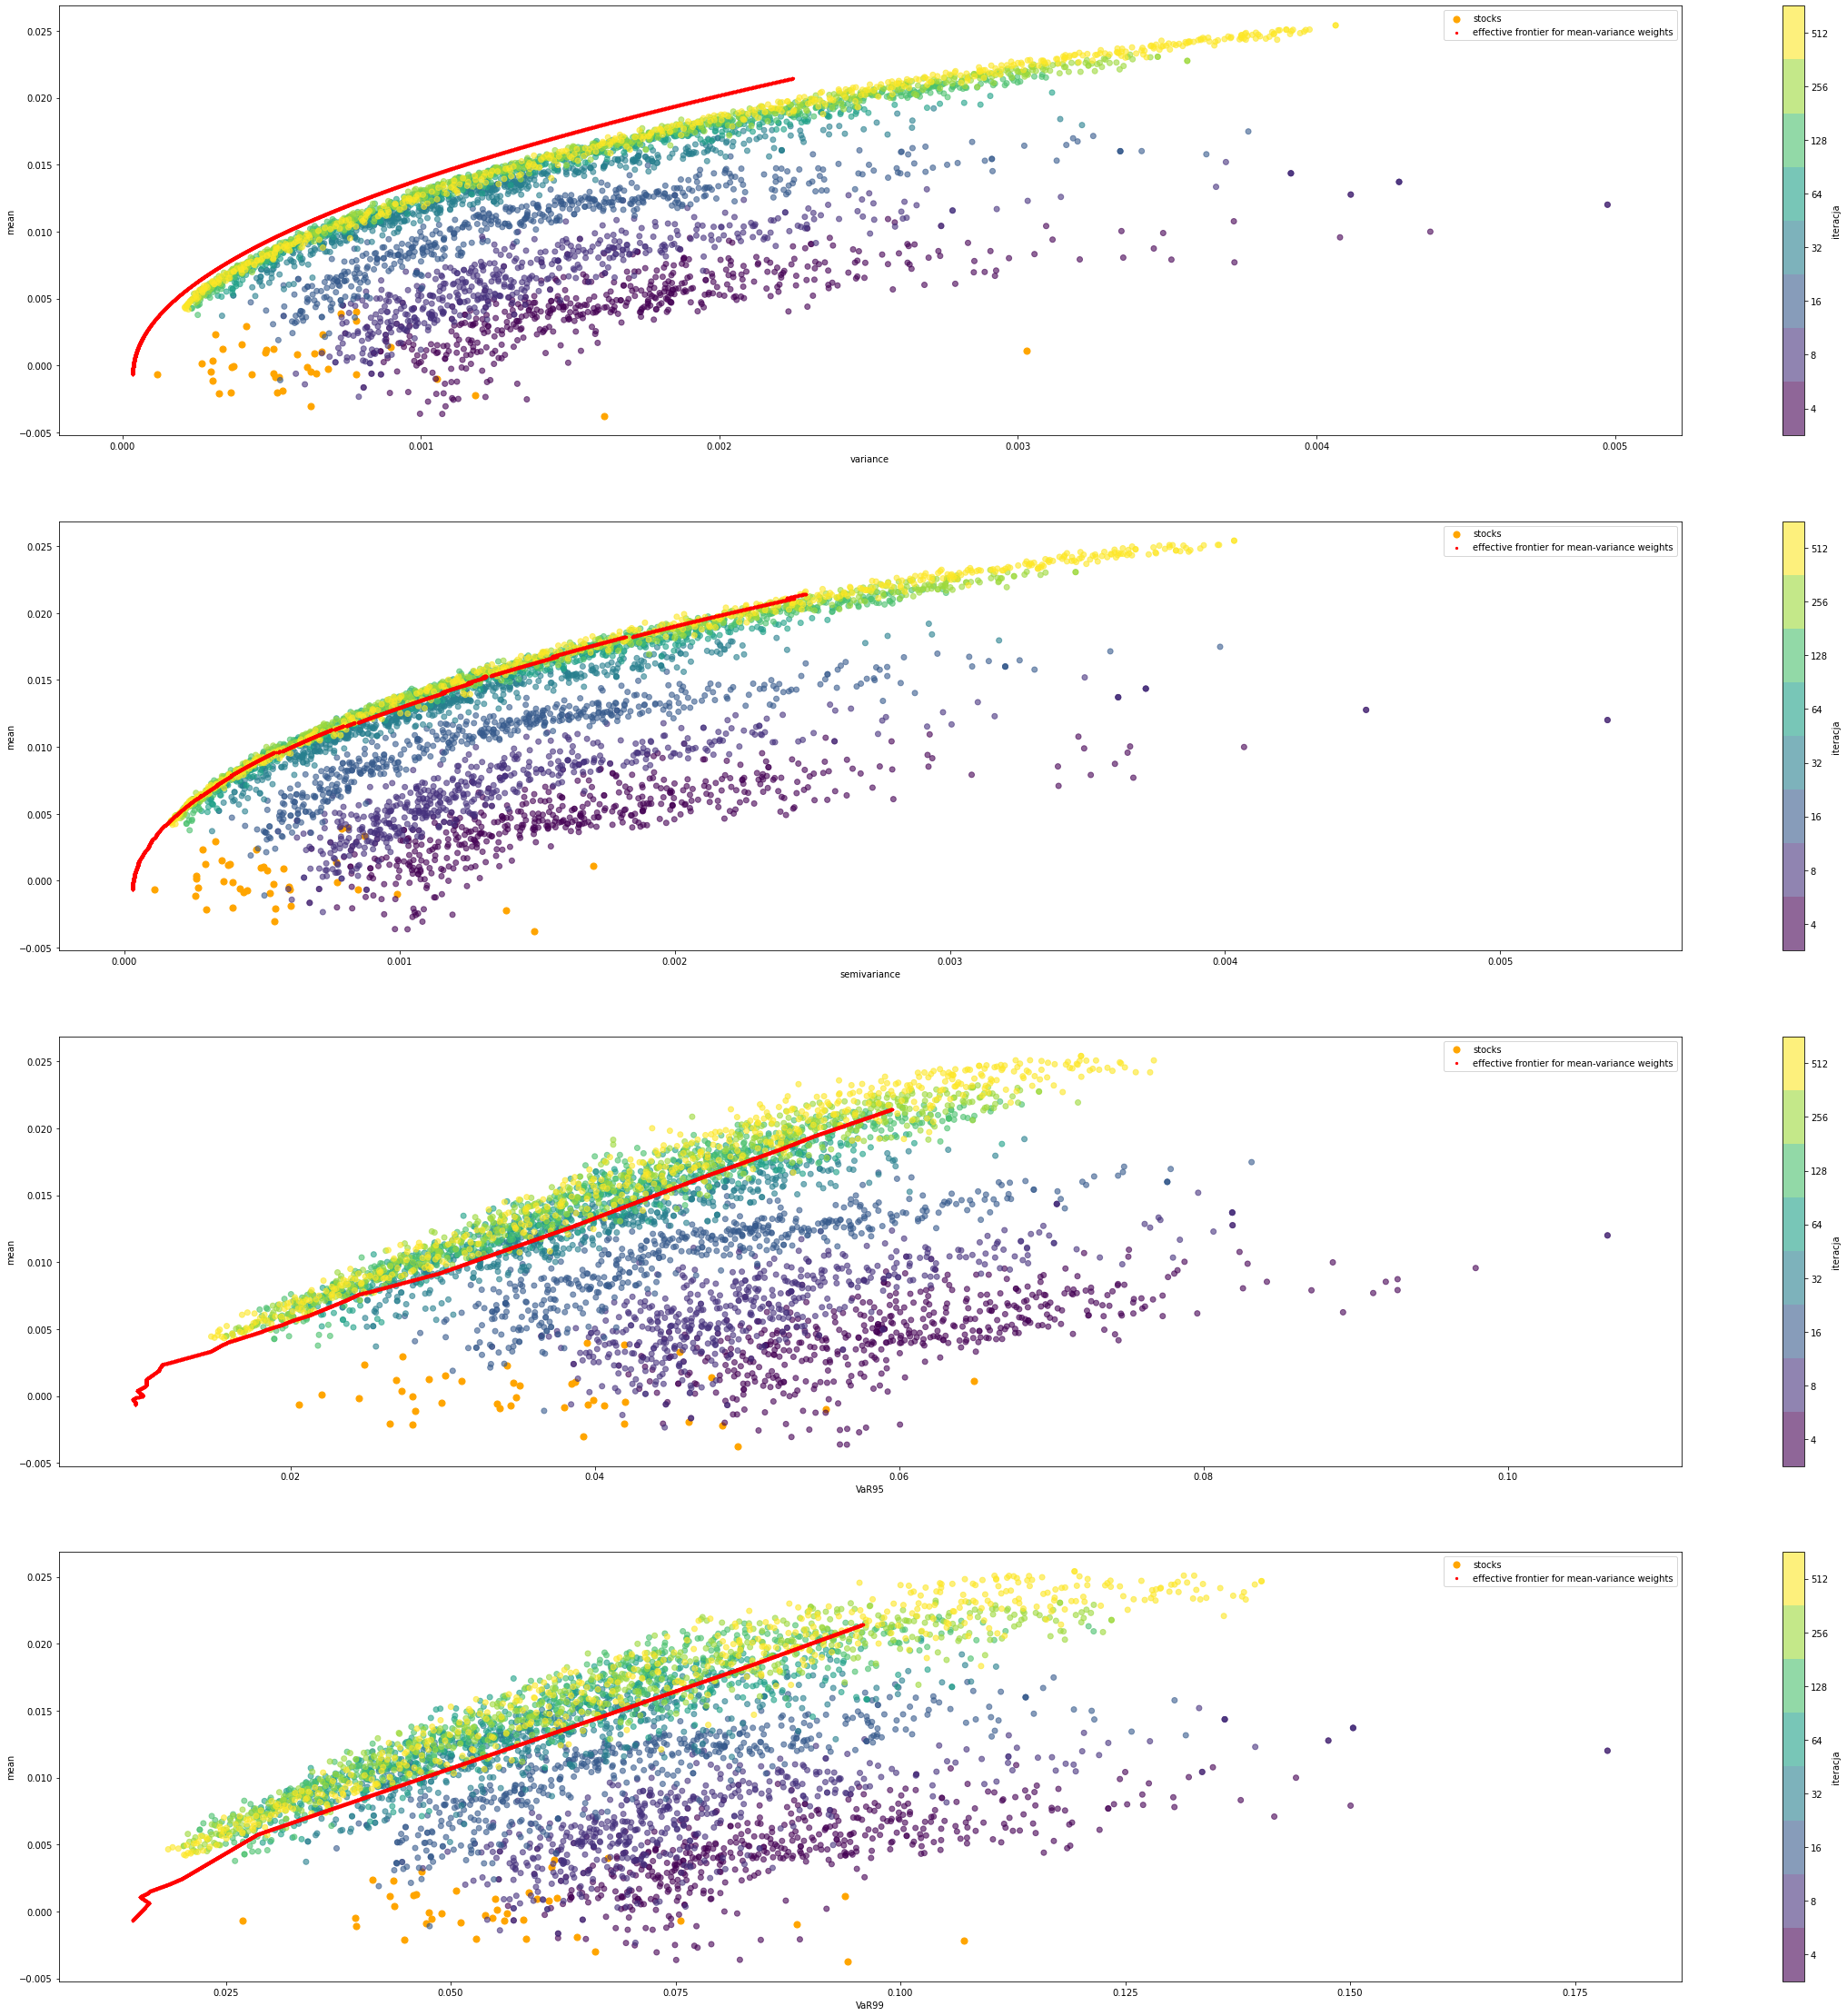

In [19]:
fig, axs = plt.subplots(4, 1, figsize=(40, 10 * 4))
temp_df.plot("variance", "mean", kind="scatter", ax=axs[0], label="stocks", c="orange", s=50, marker="o")
temp_df.plot("semivariance", "mean", kind="scatter", ax=axs[1], label="stocks", c="orange", s=50, marker="o")
temp_df.plot("VaR95", "mean", kind="scatter", ax=axs[2], label="stocks", c="orange", s=50, marker="o")
temp_df.plot("VaR99", "mean", kind="scatter", ax=axs[3], label="stocks", c="orange", s=50, marker="o")

bounds = np.exp2(np.arange(2, 11)).astype(int)
cmap = mpl.cm.get_cmap("viridis")
norm = mpl.colors.BoundaryNorm(bounds / 1.5, cmap.N)
idxs = bounds[:-1] - 1

for obj, ax in zip(range(1, history.shape[-1]), axs):
    c = ax.scatter(history[idxs, :, obj], -history[idxs, :, 0], c=np.broadcast_to(idxs[..., None], (idxs.shape[0], history.shape[1])), cmap=cmap, norm=norm, alpha=0.6)
    fig.colorbar(c, ax=ax, label="iteracja", ticks=idxs+1)

axs[0].scatter(portfolios_vars(weights_arr, SIGMA), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
axs[1].scatter(portfolios_semivariances(weights_arr, np.asarray(df)), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
axs[2].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.95), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
axs[3].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.99), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)

for ax in axs:
    ax.legend()
plt.show()